# Forecast Suitable Zipcodes for Starbucks locations :
## Based on the attributes of zipcdoes that have starbucks, analyse rest of the zipcodes in US and recommend potential locations

In [1]:
#%matplotlib notebook
import zipfile
import gmaps
import gmaps.datasets
import os
import pandas as pd
import kaggle
import requests
import json
from census import Census
import matplotlib.pyplot as plt
import requests
import json
from pygeocoder import Geocoder, GeocoderError
from pyzipcode import ZipCodeDatabase
import scipy.stats as stats

# Census API Key
from config import census_key, gkey
c = Census(census_key, year=2013)
gmaps.configure(api_key=gkey)

#url for google geocode api
basegeo_url = "https://maps.googleapis.com/maps/api/geocode/json"

### Download Starbucks dataset from kaggle & uncompress it

In [2]:
#Retrive the dataset from kaggle and move to Resources folder
os.system('kaggle datasets download -d starbucks/store-locations' )
os.system('mv -f ./store-locations.zip ./Resources/')

0

In [3]:
#Unzip the dataset downloaded from kaggle
zip_file = os.path.join('Resources', 'store-locations.zip' )
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('Resources')
zip_ref.close()

In [4]:
#Read starbucks file into a dataframe
str_file = os.path.join('Resources','directory.csv')
str_df = pd.read_csv(str_file)
str_df.head(5)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


In [5]:
#Create a dataframe for starbucks in USA 
str_df_us = str_df.loc[str_df['Country'] == 'US']
str_df_us.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
11964,Starbucks,3513-125945,Safeway-Anchorage #1809,Licensed,5600 Debarr Rd Ste 9,Anchorage,AK,US,995042300,907-339-0900,GMT-09:00 America/Anchorage,-149.78,61.21
11965,Starbucks,74352-84449,Safeway-Anchorage #2628,Licensed,1725 Abbott Rd,Anchorage,AK,US,995073444,907-339-2800,GMT-09:00 America/Anchorage,-149.84,61.14
11966,Starbucks,12449-152385,Safeway - Anchorage #1813,Licensed,1501 Huffman Rd,Anchorage,AK,US,995153596,907-339-1300,GMT-09:00 America/Anchorage,-149.85,61.11
11967,Starbucks,24936-233524,100th & C St - Anchorage,Company Owned,"320 W. 100th Ave, 100, Southgate Shopping Ctr ...",Anchorage,AK,US,99515,(907) 227-9631,GMT-09:00 America/Anchorage,-149.89,61.13
11968,Starbucks,8973-85630,Old Seward & Diamond,Company Owned,1005 E Dimond Blvd,Anchorage,AK,US,995152050,907-344-4160,GMT-09:00 America/Anchorage,-149.86,61.14


### Create new column - Zipcode from existing Postalcode

In [7]:
#Add a new column - Zipcode & populate it from Postcode
str_df_us['Zipcode'] = '00000'
str_df_us.Zipcode = str_df_us.Postcode.astype(str).str[0:5]
str_df_us.count()

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Brand             13608
Store Number      13608
Store Name        13608
Ownership Type    13608
Street Address    13608
City              13608
State/Province    13608
Country           13608
Postcode          13607
Phone Number      13122
Timezone          13608
Longitude         13608
Latitude          13608
Zipcode           13608
dtype: int64

### Data Cleansing - populate missing postalcode using address from Google Geocode

In [8]:
#Get Zipcodes from Google Geocode API for records without a Poscode.
for index, row in str_df_us.iterrows():
    if (  str(   (row)['Postcode']   )  == 'nan'  ):
        #print(index, row)
        address = row['Street Address'] + ' ' + row['State/Province'] + ' ' + row['Country']
        params = { 'address' : address  , 'key' : gkey }
        #print(address)
        response = requests.get(basegeo_url, params=params).json()
        pc = response['results'][0]['address_components'][7]['short_name']
        str_df_us.loc[str_df_us['Store Number'] == row['Store Number'], 'Zipcode'] = pc

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Download census data

In [9]:
#Get census data
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E",
                          "B23025_002E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_002E": "Employment Labor Force",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Employment Labor Force", "Poverty Rate"]]

census_pd.head()

,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Employment Labor Force,Poverty Rate
0,08518,5217.0,41.5,74286.0,33963.0,170.0,3220.0,3.258578
1,08520,27468.0,37.4,90293.0,37175.0,1834.0,16187.0,6.676860
2,08525,4782.0,47.1,118656.0,59848.0,43.0,3004.0,0.899205
3,08527,54867.0,42.2,88588.0,37021.0,2191.0,29204.0,3.993293
4,08528,245.0,48.5,58676.0,49117.0,0.0,130.0,0.000000


In [10]:
#Merge Starbucks and Census dataframes on Zipcode
data_df = census_pd.merge(str_df_us, how = 'outer', on="Zipcode")
data_df.head()

,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Employment Labor Force,Poverty Rate,Brand,Store Number,...,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,08518,5217.0,41.5,74286.0,33963.0,170.0,3220.0,3.258578,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,08520,27468.0,37.4,90293.0,37175.0,1834.0,16187.0,6.676860,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,08525,4782.0,47.1,118656.0,59848.0,43.0,3004.0,0.899205,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,08527,54867.0,42.2,88588.0,37021.0,2191.0,29204.0,3.993293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,08528,245.0,48.5,58676.0,49117.0,0.0,130.0,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleansing - Standardize Brandname

In [11]:
# Data Analysis - standardizing names for Starbucks

data_df['Brand'] = data_df['Brand'].str.strip().replace("Teavana","Starbucks")
data_df['Brand'] = data_df['Brand'].str.strip().replace("Evolution Fresh","Starbucks")
data_df['Brand'] = data_df['Brand'].str.strip().replace("Coffee House Holdings","Starbucks")

## Data Analysis - Plot the Mean for the variables chosen for analysis

In [12]:
# Extracting information only for Starbucks zipcodes which have valid census data
SB_df = data_df.loc[data_df["Brand"] == "Starbucks",:]

In [13]:
# Extracting only zipcocodes which have a value greater than 0.
SB_HHI_df = SB_df.loc[SB_df["Household Income"] >= 0,:]
SB_HHI_df["Household Income"].mean()

65912.27100675357

In [14]:
# Determing the mean for Employment Percent

data_df['Employment_PCT'] = ''
data_df['Employment_PCT'] = data_df['Employment Labor Force'] * 100 / data_df['Population']
empl_data_df = data_df[pd.notnull(data_df['Store Number'])  & data_df['Employment Labor Force'] > 0 ]
empl_data_df['Employment_PCT'].mean()

53.74278323055918

In [15]:
# determing the mean for Median Age

SB_ma_df = SB_df.loc[SB_df["Median Age"] >= 0,:]
SB_ma_df["Median Age"].mean()


37.24981679270289

In [16]:
# Extracting only zipcocodes which have a value greater than 0.

SB_pci_df = SB_df.loc[SB_df["Per Capita Income"] >= 0,:]
SB_pci_df["Per Capita Income"].mean()

35435.6777665133

In [17]:
# grouping by state for Employment PCT

empl_grp = empl_data_df.groupby(by = 'State/Province')
empl_epct_grp_mean = empl_grp['Employment_PCT'].mean()
#empl_epct_grp_mean

In [18]:
# grouping by state for Median Age

empl_grp_ma = SB_ma_df.groupby(by = 'State/Province')
empl_grp_ma_mean = empl_grp_ma['Median Age'].mean()
#empl_grp_ma_mean

In [19]:
# grouping by state for hh income

str_grp = SB_HHI_df.groupby(by = 'State/Province')
str_grp_cnt = str_grp['Household Income'].mean()
#str_grp_cnt

In [20]:
# Grouping by State for Per Capita Income

str_grp_pci = SB_pci_df.groupby(by = 'State/Province')
str_grp_pci_mean = str_grp['Per Capita Income'].mean()
#str_grp_pci_mean

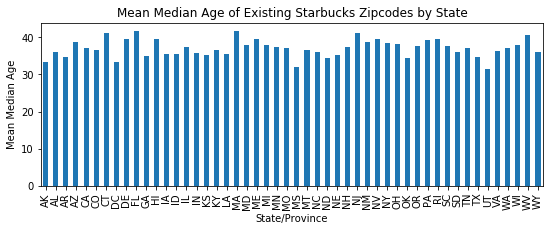

In [21]:
# Plot for Mean Media Age

empl_grp_ma_mean.plot(kind="bar", title = "Mean Median Age of Existing Starbucks Zipcodes by State", figsize = (9,3))
plt.ylabel("Mean Median Age")
plt.savefig('Starbucks_Mean Median Age')
plt.show()

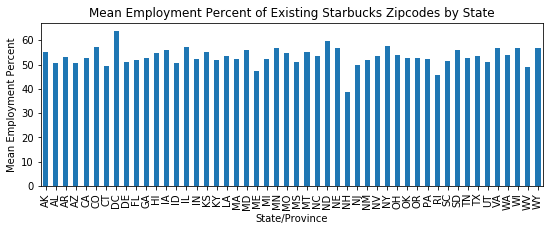

In [22]:
# Plot for Employment PCT

empl_epct_grp_mean.plot(kind="bar", title = "Mean Employment Percent of Existing Starbucks Zipcodes by State", figsize = (9,3))
plt.ylabel("Mean Employment Percent")
plt.savefig('Starbucks_Mean Employment Percent')
plt.show()

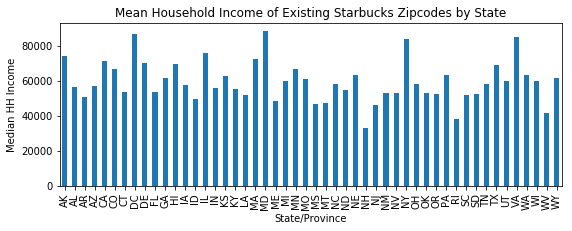

In [23]:
# Plot for Mediana HH Income

str_grp_cnt.plot(kind="bar", title = "Mean Household Income of Existing Starbucks Zipcodes by State", figsize = (9,3))
plt.ylabel("Median HH Income")
plt.savefig('Starbucks_Mean HH Income')
plt.show()


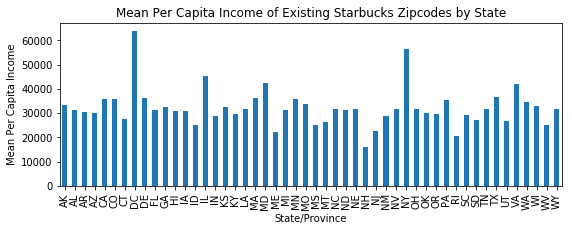

In [24]:
# plot for Mean Per capita income

str_grp_pci_mean.plot(kind="bar", title = "Mean Per Capita Income of Existing Starbucks Zipcodes by State", figsize = (9,3))
plt.ylabel("Mean Per Capita Income")
plt.savefig('Starbucks_Mean Per Capita Income')
plt.show()

### Plot - 
     1. Starbucks latlong on Google maps
     2. Number of Stores by State
     3. Heatmap for number of stores 

In [25]:
#Get lat, long for Starbucks stores
locations = str_df_us[["Latitude", "Longitude"]].astype(float)

In [26]:
#Plot the lat long on Google map
fig = gmaps.figure()

starbucks_layer = gmaps.symbol_layer(locations, fill_color='green', stroke_color='green', scale=2)
fig.add_layer(starbucks_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [27]:
#Group the starbucks dataset by State
str_grp = str_df_us.groupby(by = 'State/Province')
str_grp_cnt = str_grp['Store Number'].count()

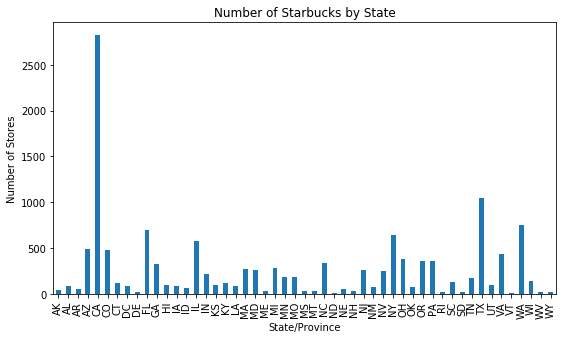

In [28]:
#Bar chart of Number of Stores by State
str_grp_cnt.plot(kind="bar", title = "Number of Starbucks by State", figsize = (9,5))
plt.ylabel("Number of Stores")
plt.savefig('Starbucks_Stores_State_Count')

In [29]:
#Read in the state vs. Lat long file
state_ll = os.path.join('Resources', 'state_lat_long.csv')
state_ll_df = pd.read_csv(state_ll)

In [30]:
#Merge the starbucks and State Lat Long dataframes
str_ll_new = str_df_us.merge(state_ll_df, how = 'inner', on="State/Province")

In [31]:
#Group the merged dataframe by State
str_ll_new_grp = str_ll_new.groupby(by = 'State/Province')
lat = str_ll_new_grp['Latitude_y'].min()
lng = str_ll_new_grp['Longitude_y'].min()

In [32]:
#Create a dataframe with State Lat Long, Number of stores
str_last_df = pd.DataFrame({ 'Lat' : lat, 'Lng' : lng, 'count' : str_grp['Store Number'].count() })

In [33]:
#Draw a heat map of Starbucks by State
#df = gmaps.datasets.load_dataset_as_df(str_last_df)
# dataframe with columns ('latitude', 'longitude', 'magnitude')
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer( str_last_df[['Lat', 'Lng']], dissipating = False, weights=str_last_df['count'], max_intensity=100, point_radius=3.0 )
heatmap_layer.dissipating = False
heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 1
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

### Box plot for the variables 

In [34]:
#Replacing all sister concerns of Starbucks ('Teavana', 'Evolution Fresh','Coffee House Holdings') to Starbucks

data_df['Brand'] = data_df['Brand'].str.strip().replace("Teavana","Starbucks")
data_df['Brand'] = data_df['Brand'].str.strip().replace("Evolution Fresh","Starbucks")
data_df['Brand'] = data_df['Brand'].str.strip().replace("Coffee House Holdings","Starbucks")

type_df = data_df.loc[data_df["Brand"] == "Starbucks",:]

Mean age of all Starbucks locatin in US is 37.473168936326836 and Standard Deviation is 6.830306956725909


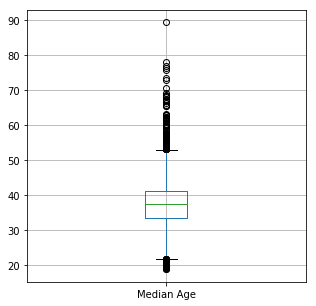

In [35]:
# Median age of Starbucks Zip code

grouped_combined_df = type_df.groupby(["Zipcode"])

grouped_combined_df_age = grouped_combined_df['Median Age'].mean()

grouped_combined_df_brand = grouped_combined_df['Brand'].first()

grouped_df_new= pd.DataFrame({"Brand": grouped_combined_df_brand, "Median Age":grouped_combined_df_age })

type_final_df = grouped_df_new[(grouped_df_new['Median Age'] >= 0)]

mean_age = type_final_df["Median Age"].mean()

std_mean_age = type_final_df["Median Age"].std(ddof=0)

print(f"Mean age of all Starbucks locatin in US is {mean_age} and Standard Deviation is {std_mean_age}")

type_final_df.boxplot(column='Median Age', figsize = (5,5))

In [36]:
# Extracting information only for Starbucks zipcodes which have valid census data
SB_df = data_df.loc[data_df["Brand"] == "Starbucks",:]

In [37]:
# Extracting only zipcocodes which have a value greater than 0.
SB_HHI_df = SB_df.loc[SB_df["Household Income"] >= 0,:]

In [38]:
#Caicluate Mean and Standard deviation for Household Income
hhi_mean = SB_HHI_df['Household Income'].mean()
hhi_std = SB_HHI_df['Household Income'].std()
print(hhi_mean, hhi_std)

65912.27100675357 25717.094950947954


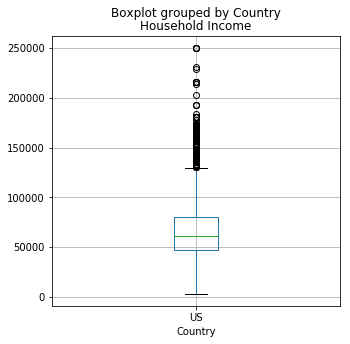

In [39]:
#Box plot for Household Income
SB_HHI_df.boxplot(column='Household Income', by='Country', figsize = (5,5))

35435.6777665133 17505.876261913785


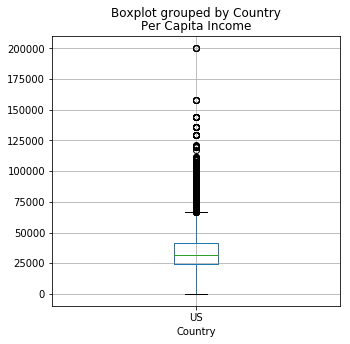

In [40]:
#Get Per capita Income greater than 0
per_capita_df = data_df.loc[ (data_df['Per Capita Income'] > 0 ) & (data_df["Brand"] == "Starbucks"),: ]

# Get the mean and Standard deviation for Per Capita Income
pci_mean = per_capita_df['Per Capita Income'].mean()
pci_std = per_capita_df['Per Capita Income'].std()

#Box plot for Per Capita Income
per_capita_df.boxplot(column='Per Capita Income', by='Country', figsize = (5,5))

print( pci_mean , pci_std)

In [41]:
# Find the Percentage of population that is employed & create new dataframe for Starbucks with census info
data_df['Employment_PCT'] = ''
data_df['Employment_PCT'] = data_df['Employment Labor Force'] * 100 / data_df['Population']
empl_data_df = data_df[pd.notnull(data_df['Store Number'])  & data_df['Employment Labor Force'] > 0 ]

In [42]:
# Get the mean and Standard deviation for Employment Percentage
empl_mean = empl_data_df['Employment_PCT'].mean()
empl_sd = empl_data_df['Employment_PCT'].std()
print(empl_mean, empl_sd)

53.74278323055918 7.6653268515194535


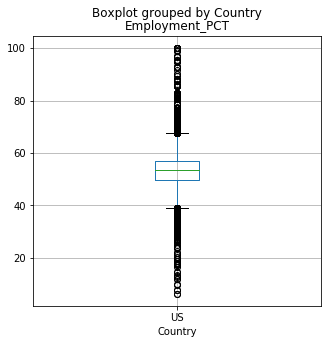

In [43]:
#Box plot for Employment Percentage
empl_data_df.boxplot(column='Employment_PCT', by='Country', figsize = (5,5))

### Add a new column with Recommended value (Y/N) 
    by comparing the non starbucks zipcode's variables within 1 SD of the mean for non starbucks zipcodes.

In [44]:
#Add a new column - Recommended & populate it to 'Y' if Census attributes are withn one SD of mean
data_df['Recommended'] = 'N'

for index , row in data_df.iterrows():
    if ( (row['Employment_PCT'] > (empl_mean - empl_sd))  &  \
         (row['Median Age']     > (mean_age - std_mean_age)) &  \
         (row['Median Age']     < (mean_age + std_mean_age))& \
         (row['Household Income'] > (hhi_mean - hhi_std)) & \
         (row['Household Income'] < (hhi_mean + hhi_std)) & \
         (row['Per Capita Income'] > (pci_mean - pci_std)) & \
         (row['Per Capita Income'] < (pci_mean + pci_std)) & \
         (str(row['Store Number']) == 'nan')): \
        data_df.loc[data_df['Zipcode'] == row['Zipcode'], 'Recommended'] = 'Y'    

In [45]:
#Number of records that are Recommended
data_df['Recommended'].value_counts()

N    33308
Y     7957
Name: Recommended, dtype: int64

In [46]:
#Create a dataframe with recommended set 
rec_df = data_df.loc[data_df['Recommended'] == 'Y']

### Create a list of all zipcodes within 2 miles of Starbucks Zipcode.
    This will be used to eliminate recommemdations

In [47]:
#Create a list with all zipcodes with 2 miles of Starbucks zipcode.
zcdb = ZipCodeDatabase()
rec_l = []

for zipcode in str_df_us.Zipcode:
    try:
        rec_l.append([z.zip for z in zcdb.get_zipcodes_around_radius(zipcode, 2)])
    except:
        print("Error")    

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Erro

In [48]:
#flatten the list
flat_list_str = [item for sublist in rec_l for item in sublist]

In [49]:
#Add a new column 'Another Store Present' and populate to 1 if there is a store within 2 miles
rec_df['Another_Store_Present'] = rec_df.Zipcode.isin(flat_list_str).astype(int)

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
#Final recommended count of Zipcodes
rec_df['Another_Store_Present'].value_counts()

0    7464
1     493
Name: Another_Store_Present, dtype: int64

In [51]:
#Create final recommendation dataframe
locations_rec = rec_df.loc[rec_df['Another_Store_Present'] == 0]
locations_rec.to_csv('./Resources/Recommended_Zipcodes.csv')

### Read in Zip to Lat Long file which is used to plot Recommended Zipcodes

In [52]:
#Read in Zip to Lat Long file
zip_ll_file = os.path.join('Resources' , 'Zip_Lat_Long.txt')
zip_ll_df = pd.read_csv(zip_ll_file)
zip_ll_df.head()

,Zipcode,Lat,Lng
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


In [53]:
rec_zip_df = pd.DataFrame(locations_rec['Zipcode'].astype(int))
rec_locations_ll = rec_zip_df.merge(zip_ll_df, how='inner', on=['Zipcode'])

In [54]:
#Plot Recommendations 
#Get lat, long of final recommendations
rec_locations_ll_df = rec_locations_ll[["Lat", "Lng"]].astype(float)

#Plot the lat long on Google map
fig = gmaps.figure()

try:
    starbucks_layer2 = gmaps.symbol_layer(rec_locations_ll_df, fill_color='red', stroke_color='red', scale=2)
except :
    print("Bad Lat Long")
    
fig.add_layer(starbucks_layer2)
fig

Figure(layout=FigureLayout(height='420px'))

In [65]:
#Plot the Existing Stores and Recommended Stores 
fig = gmaps.figure()

starbucks_layer = gmaps.symbol_layer(locations, fill_color='green', stroke_color='green', scale=1)

try:
    starbucks_layer2 = gmaps.symbol_layer(rec_locations_ll_df, fill_color='red', stroke_color='red', scale=2)
except :
    print("Bad Lat Long")

fig.add_layer(starbucks_layer)
fig.add_layer(starbucks_layer2)

fig

Figure(layout=FigureLayout(height='420px'))

### Create Barchart for Existing stores vs. Recommded stores

In [66]:
#Read in Zip to State file to get number of recommended stores by State
state_zip_file = os.path.join("Resources" , "zip_to_state.csv")
state_zip_df = pd.read_csv(state_zip_file)
state_zip_df.head()

,Zipcode,CITY,STATENAME
0,501,Holtsville,NY
1,544,Holtsville,NY
2,601,Adjuntas,PR
3,602,Aguada,PR
4,603,Aguadilla,PR


In [68]:
rec_zip_df = pd.DataFrame(locations_rec['Zipcode'].astype(int))
rec_locations_ll = rec_zip_df.merge(state_zip_df, how='inner', on=['Zipcode'])
rec_locations_gr = rec_locations_ll.groupby('STATENAME')['Zipcode'].count()
rec_locations_gr.to_csv('./Resources/Recommedations_Count_By_State.csv')

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [58]:
final_df = pd.DataFrame({"Recommded_Count" : rec_locations_gr , "Existing_Count" : str_grp_cnt})

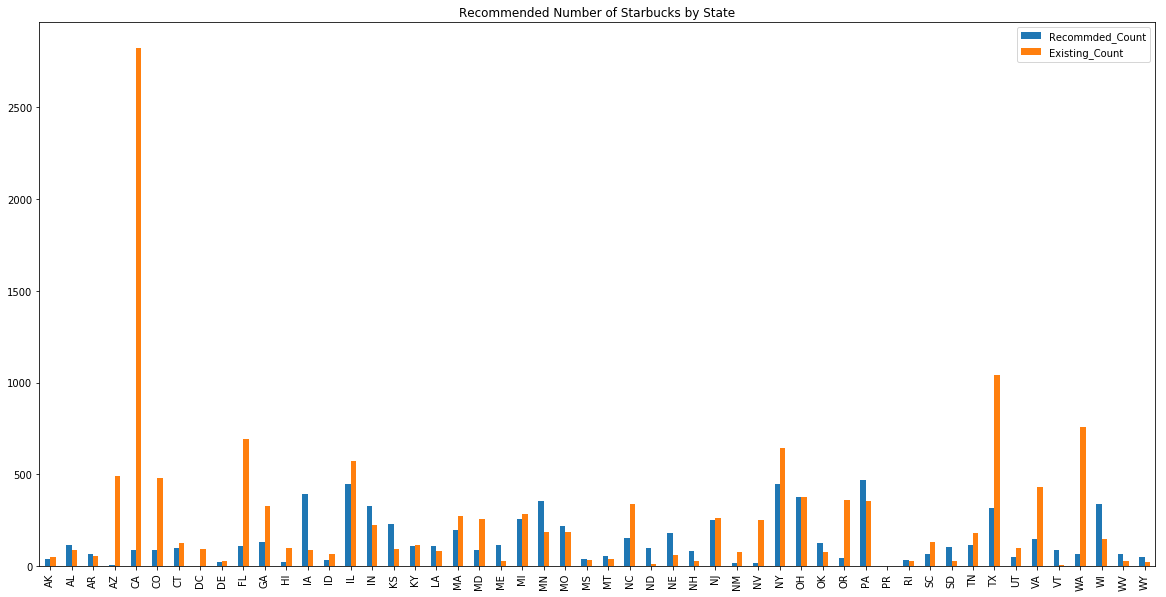

In [59]:
final_df.plot(kind="bar", title = "Recommended Number of Starbucks by State", figsize = (20,10))


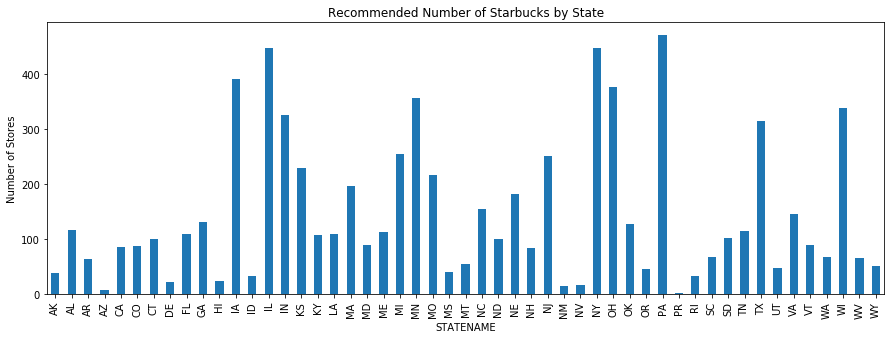

In [60]:
#Bar chart of Recommeded Number of Stores by State
rec_locations_gr.plot(kind="bar", title = "Recommended Number of Starbucks by State", figsize = (15,5))
plt.ylabel("Number of Stores")
plt.savefig('Recommeded_Stores_By_State_Count')

In [61]:
#Independant Testing for Household Income
data_df_sb = data_df.loc[ (data_df['Brand'] == 'Starbucks')  &  (data_df['Household Income'] > 0) ]
data_df_sb.rename(columns={'Household Income':'Household_Income'}, inplace=True)
data_df_sb['Household_Income'].mean()

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


65912.27100675357

In [62]:
data_df_nonsb = data_df.loc[ (data_df['Brand'] != 'Starbucks')  & (data_df['Household Income'] > 0) ]
data_df_nonsb.rename(columns={'Household Income':'Household_Income'}, inplace=True)
data_df_nonsb['Household_Income'].mean()

49831.61869341448

# Independent t-test for Starbucks Zipcodes vs. Non Starbucks Zipcodes


In [63]:
# Calculate Independent (Two Sample) T-Test
stats.ttest_ind(data_df_sb.Household_Income, data_df_nonsb.Household_Income, equal_var=False)

Ttest_indResult(statistic=61.37455871570821, pvalue=0.0)

In [64]:
# Since p value is less than 0.05, Null Hypothesis is rejected.
# Null Hypothesis - There is no difference in Household Income between zipcodes with Starbucks and Zipcodes w/o SB.

In [69]:
#Independant Testing for Per Capita Income
pci_df_sb = data_df.loc[ (data_df['Brand'] == 'Starbucks')  & (data_df['Per Capita Income'] > 0) ]
pci_df_sb.rename(columns={'Per Capita Income':'Per_Capita_Income'}, inplace=True)
pci_df_sb['Per_Capita_Income'].mean()

35435.6777665133

In [70]:
pci_df_nonsb = data_df.loc[ (data_df['Brand'] != 'Starbucks')  & (data_df['Per Capita Income'] > 0) ]
pci_df_nonsb.rename(columns={'Per Capita Income':'Per_Capita_Income'}, inplace=True)
pci_df_nonsb['Per_Capita_Income'].mean()

24788.634013204

In [71]:
# Calculate Independent (Two Sample) T-Test
stats.ttest_ind(pci_df_sb.Per_Capita_Income, pci_df_nonsb.Per_Capita_Income, equal_var=False)

Ttest_indResult(statistic=63.51504537189606, pvalue=0.0)

In [ ]:
# Since p value is less than 0.05, Null Hypothesis is rejected.
# Null Hypothesis - There is no difference in Percapita Income Income between zipcodes with Starbucks and Zipcodes w/o SB.

In [72]:
#Independant Testing for Median Age
mi_df_sb = data_df.loc[ (data_df['Brand'] == 'Starbucks')  & (data_df['Median Age'] > 0) ]
mi_df_sb.rename(columns={'Median Age':'Median_Age'}, inplace=True)
mi_df_sb['Median_Age'].mean()

37.24981679270289

In [73]:
#Independant Testing for Per Capita Income
mi_df_nonsb = data_df.loc[ (data_df['Brand'] != 'Starbucks')  & (data_df['Median Age'] > 0) ]
mi_df_nonsb.rename(columns={'Median Age':'Median_Age'}, inplace=True)
mi_df_nonsb['Median_Age'].mean()

42.28496777757319

In [75]:
# Calculate Independent (Two Sample) T-Test
stats.ttest_ind(mi_df_sb.Median_Age, mi_df_nonsb.Median_Age, equal_var=False)

Ttest_indResult(statistic=-66.22569462383159, pvalue=0.0)

In [ ]:
# Since p value is less than 0.05, Null Hypothesis is rejected.
# Null Hypothesis - There is no difference in Median Age between zipcodes with Starbucks and Zipcodes w/o SB.

In [76]:
#Independant Testing for Employment_Percentage
epct_df_sb = data_df.loc[ (data_df['Brand'] == 'Starbucks')  & (data_df['Employment Labor Force'] > 0) ]
epct_df_sb['Employment_PCT'] = data_df['Employment Labor Force'] * 100 / data_df['Population'] 
epct_df_sb['Employment_PCT'].mean()

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


53.74278323055918

In [77]:
epct_df_nonsb = data_df.loc[ (data_df['Brand'] != 'Starbucks')  & (data_df['Employment Labor Force'] > 0) ]
epct_df_nonsb['Employment_PCT'] = data_df['Employment Labor Force'] * 100 / data_df['Population'] 
epct_df_nonsb['Employment_PCT'].mean()

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


48.37130822384591

In [78]:
# Calculate Independent (Two Sample) T-Test
stats.ttest_ind(epct_df_sb.Employment_PCT, epct_df_nonsb.Employment_PCT, equal_var=False)

Ttest_indResult(statistic=58.003017863004516, pvalue=0.0)

In [ ]:
# Since p value is less than 0.05, Null Hypothesis is rejected.
# Null Hypothesis - There is no difference in Employment Percentage between zipcodes with Starbucks and Zipcodes w/o SB.